In [2]:
%load_ext autoreload
%autoreload 2
from rl4co.envs.routing import PDPTWEnv, PDPTWGenerator
from rl4co.models.zoo import AttentionModel
from ortools_solver import darp_solver
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.models.rl import PPO

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
env=PDPTWEnv()

In [7]:
import torch
from rl4co.models.zoo import AttentionModelPolicy
from rl4co.envs.routing import PDPTWEnv

env = PDPTWEnv()

# Load checkpoint

model_checkpoint = AttentionModel.load_from_checkpoint("checkpoints/sf_newenv_2/last-v1.ckpt", strict=False, map_location='cpu', env=env)

/home/jiangwolin/venvs/gpuenv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/jiangwolin/venvs/gpuenv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
/home/jiangwolin/venvs/gpuenv/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['baseline.baseline.policy.encoder.init_embedding.project.weight', 'baseline.baseline.policy.encoder.init_embedding.project.bias', 'baseline.baseline.policy.encoder.net.layers.0.0.module.Wqkv.weight', 'baseline.baseline.policy.encoder.net.layers.0.0.module.Wqkv.bias', 'base

In [8]:
# Initiate untrained policy
untrained_policy = AttentionModelPolicy(env_name=env.name,
                                        embed_dim = 128,
                                        num_encoder_layers=3,
                                        num_heads=8)

In [9]:
device = 'cpu'

td_init = PDPTWEnv(generator_params={"num_customers":30}).reset(batch_size=[1]).to(device)

trained_policy = model_checkpoint.policy.to(device)

trained_out = trained_policy(td_init.clone(), phase="test", decode_type="sampling", return_actions=True)
untrained_out = untrained_policy(td_init.clone(), phase="test", decode_type="sampling", return_actions=True)

actions_trained = trained_out['actions'].cpu().detach()
actions_untrained = untrained_out["actions"].cpu().detach()

rewards_trained = trained_out['reward']
rewards_untrained = untrained_out['reward']

import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(2,1, figsize=(11,20))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}, \
                     Feasibility = {untrained_out["feasibility"][i][0]}, \
                        Vehicles = {untrained_out["vehicles_used"][i][0]+1}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-rewards_trained[i].item():.3f}, \
                     Feasibility = {trained_out['feasibility'][i][0]}, \
                        Vehicles = {trained_out["vehicles_used"][i][0].item()+1}")

SyntaxError: f-string: unmatched '[' (3099554912.py, line 22)

In [ ]:
device = 'cpu'

td_init = PDPTWEnv(generator_params={"num_customers":30}).reset(batch_size=[1]).to(device)

trained_policy = model_checkpoint.policy.to(device)

trained_out = trained_policy(td_init.clone(), phase="test", decode_type="sampling", return_actions=True)
untrained_out = untrained_policy(td_init.clone(), phase="test", decode_type="sampling", return_actions=True)


In [ ]:
from tqdm import tqdm

records = {}

for i in tqdm(range(5, 6, 5)):
    or_tools = []
    neural = []

    for j in tqdm(range(60)):  # Each instance run for j times
        td_init = PDPTWEnv(generator_params={"num_customers": i}).reset(batch_size=[1]).to(device)

        neural_out = trained_policy(
            td_init.clone(),
            phase="test",
            decode_type="greedy",
            return_actions=True,
        )
        print(neural_out)
        or_out = darp_solver(td_init, time_limit_seconds=1)

        # be careful: neural_out["reward"] is probably a tensor → convert to scalar if needed
        neural.append((- neural_out["reward"] - neural_out["waiting_penalty"]).detach().cpu().item())
        or_tools.append(or_out["total_distance"])

    # create the entry for this i
    records[f"{i} req"] = {
        "or_tools": or_tools,
        "neural": neural,
    }

{'reward': tensor([-817.8667]),
 'log_likelihood': tensor([-16.5396], grad_fn=<SumBackward1>),
 'actions': tensor([[17, 27, 29,  5, 18, 28,  6,  9, 47,  3, 10, 48,  7,  8,  0, 11, 30, 12,
          57, 37, 58,  4,  0, 31, 49, 32,  1, 41,  2, 42, 23, 43, 24, 45, 19, 20,
          46, 39, 53, 40, 51, 54, 25, 52, 26, 59, 55, 60, 56,  0, 21, 22, 13, 35,
          15, 36, 16, 33, 34,  0, 38, 50, 14,  0, 44,  0]])}

In [21]:
td_init["time_windows"][0][57]

tensor([1350., 1380.])

In [33]:
oracle = []
for i in range(1):
    td_init = PDPTWEnv(generator_params={"num_customers":30}).reset(batch_size=[1]).to(device)
    or_out = solve_darp_with_ortools(td_init, time_limit_seconds=1)
    oracle.append(or_out)


In [38]:
oracle[0]["routes"][0]

[15, 49, 37, 16, 38, 50, 55, 25, 29, 56, 26, 30, 23, 24, 57, 51, 58, 52]

In [117]:
or_results

{'total_distance': 78.6431901476605,
 'vehicles_used': 3,
 'routes': [[7, 8, 5, 17, 6, 18],
  [9, 10, 11, 12],
  [19, 13, 20, 14, 15, 16, 3, 1, 4, 2]]}

In [22]:
td["time_windows"][10]

tensor([545., 575.])

In [81]:
from tqdm import tqdm

records = {}

for i in tqdm(range(30, 31, 5)):
    or_tools = []
    neural = []

    for j in tqdm(range(60)):  # Each instance run for j times
        td_init = PDPTWEnv(generator_params={"num_customers": i}).reset(batch_size=[1]).to(device)

        neural_out = trained_policy(
            td_init.clone(),
            phase="test",
            decode_type="greedy",
            return_actions=True,
        )
        print(neural_out)
        or_out = solve_darp_with_ortools(td_init, time_limit_seconds=1)

        # be careful: neural_out["reward"] is probably a tensor → convert to scalar if needed
        neural.append((- neural_out["reward"] - neural_out["waiting_penalty"]).detach().cpu().item())
        or_tools.append(or_out["total_distance"])

    # create the entry for this i
    records[f"{i} req"] = {
        "or_tools": or_tools,
        "neural": neural,
    }
"""
import json
with open("record.json", "w") as f:
    json.dump(records, f, indent=4)"""

  0%|          | 0/1 [00:00<?, ?it/s]

{'reward': tensor([-228.5817]), 'log_likelihood': tensor([-10.8765], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[4.0944]]), 'actions': tensor([[11, 43, 45, 31, 12, 33, 44, 32, 46, 34, 17, 18, 27, 28, 35,  7, 59, 36,
         60,  8, 47, 48, 41,  5, 42,  6, 49, 57, 39, 40, 58, 50, 51,  9, 15, 29,
         52, 25, 10, 30, 16, 26, 19, 20,  0, 53, 54, 55, 13, 37, 56, 14, 38,  1,
          2, 21, 23,  3, 22,  4, 24]])}


{'reward': tensor([-215.9702]), 'log_likelihood': tensor([-10.7218], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[37.0272]]), 'actions': tensor([[13, 57, 19, 41, 58, 37, 14, 20, 42, 38, 17, 18, 29, 27, 30, 33, 28,  5,
         34, 15,  7,  6,  8, 16, 35, 45, 31, 43, 32, 51, 36, 46, 44, 52, 53, 54,
         23, 59, 25, 39, 24, 55, 40, 47, 26, 60, 56, 48,  0,  3,  4,  1,  2, 49,
          9, 50, 10, 11, 21, 12, 22]])}


{'reward': tensor([-268.6387]), 'log_likelihood': tensor([-11.5000], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[2]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[54.3278]]), 'actions': tensor([[17, 25, 39, 29, 26, 18, 30, 40, 21,  9,  3, 22, 10,  4, 43, 44, 13, 49,
         14, 53, 50, 54, 35, 57, 41, 36, 58, 42,  5, 27,  6, 15, 59, 28, 16, 60,
         23, 24,  0, 47, 48, 37, 33, 38, 34,  7, 11,  1,  8, 19, 45, 20, 55, 46,
         51,  2, 12, 56, 52,  0, 31, 32]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-408.5126]), 'log_likelihood': tensor([-11.8451], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[2]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[184.3698]]), 'actions': tensor([[ 3, 37, 49,  4, 50, 38,  1, 43, 39, 47,  2, 44, 40, 48, 13, 51, 52, 14,
         41, 53, 54, 42, 27, 15, 28,  7, 16,  8, 21, 29, 31, 22, 59, 11, 32, 19,
         30, 55, 60, 12, 20, 56,  0, 35,  9, 33, 57, 10, 17, 36, 34, 58, 18, 23,
         24,  0, 25, 45,  5, 26,  6, 46]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-481.9370]), 'log_likelihood': tensor([-11.0703], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[2]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[238.0228]]), 'actions': tensor([[11, 15, 37, 38, 12, 16, 17, 39, 47, 18, 40, 25, 27, 48,  5, 19, 28, 26,
         55, 13,  6, 20, 56, 14, 59, 45, 46, 60,  1,  2, 41,  3, 43, 57, 42, 49,
          4, 58, 23, 50, 44, 24,  0, 51, 52, 53, 54, 29, 30, 31, 33, 34, 35, 32,
         36, 21, 22,  0,  7,  9, 10,  8]])}


{'reward': tensor([-237.8083]), 'log_likelihood': tensor([-12.1368], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[6.7264]]), 'actions': tensor([[ 3, 49, 41, 42, 50,  4, 53, 54, 43, 44, 19, 51, 20, 52, 27, 35, 28, 36,
         17, 15, 16, 18, 45, 47, 59, 46, 29, 48, 30, 60, 57,  5, 58, 13,  6, 25,
         21, 14, 37, 23, 26,  7, 22, 24,  8, 38, 55, 56,  0, 11, 31, 12, 32,  9,
         10, 33, 34, 39, 40,  1,  2]])}


{'reward': tensor([-340.4749]), 'log_likelihood': tensor([-8.6032], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[2]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[124.1085]]), 'actions': tensor([[51, 53,  7, 52,  8, 54, 43, 44, 47, 25, 55, 27, 48, 26, 28, 56, 35, 15,
         16, 13, 36, 14, 41, 29, 42, 30, 23, 59, 24, 60, 19, 21,  3, 31, 20, 33,
         22, 37, 32,  4, 38, 34, 49, 50,  0, 17, 11, 57, 45, 18,  1, 12,  9, 46,
         58,  2, 10, 39, 40,  0,  5,  6]])}


{'reward': tensor([-200.2107]), 'log_likelihood': tensor([-11.3488], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[10.4755]]), 'actions': tensor([[15, 16, 55, 51, 56, 52, 31, 57, 47, 39, 32, 58, 48,  1, 40,  2, 29, 49,
         30, 25, 50, 26, 11, 45, 59, 12, 46, 60, 53, 21, 43, 23, 54,  9, 24, 44,
         22,  5, 41, 13, 10, 17, 42,  6, 14, 18,  0, 35,  3, 33, 36,  4, 34, 19,
         37,  7, 20, 38,  8, 27, 28]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-423.5073]), 'log_likelihood': tensor([-13.9957], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[2]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[195.8026]]), 'actions': tensor([[41, 37, 39, 11, 42, 38, 12, 40, 31, 55, 35, 47, 32, 19, 48, 20, 56, 36,
         57, 29, 58, 21, 30, 22, 25,  7,  3, 49, 26,  8,  4, 50, 45,  9, 17, 46,
          5, 27, 10, 18, 51, 28,  6, 52,  0, 33, 13, 15, 53, 34, 23, 54, 16, 14,
         59, 24,  1, 60,  2,  0, 43, 44]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-323.1344]), 'log_likelihood': tensor([-13.5609], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[117.0090]]), 'actions': tensor([[ 7, 35, 27, 29, 36, 23,  8, 24, 30, 28, 39,  3, 17, 57,  4, 18, 40, 58,
          1, 37, 38,  2, 19, 13, 20, 45, 14, 46,  5,  6, 31, 53, 25, 41, 54, 43,
         26, 32, 42, 49, 44, 50, 51, 52,  0,  9, 10, 47, 55, 48, 56, 21, 11, 22,
         33, 12, 59, 34, 60, 15, 16]])}


{'reward': tensor([-323.3008]), 'log_likelihood': tensor([-12.9620], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[109.1541]]), 'actions': tensor([[35, 36, 21, 22, 41, 47, 39, 29, 42,  3, 48, 30, 40,  4, 25, 26, 11, 57,
         12, 58, 53, 51, 54, 45, 52, 46, 13, 17, 18, 14, 37,  9, 33,  5,  6, 23,
         38, 10, 34, 24,  0, 43, 44, 31, 59, 19, 27, 20, 60, 32, 28,  7, 49,  8,
         15, 55, 50, 16, 56,  1,  2]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-250.5198]), 'log_likelihood': tensor([-9.4528], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[58.7689]]), 'actions': tensor([[ 7, 41, 35, 51, 42, 17, 36, 52,  8, 18, 59, 11, 23, 12, 21, 45, 60, 24,
         22, 46, 39, 13, 40, 33, 14, 53, 34, 54, 43, 47, 57, 58, 44, 15, 48, 19,
         16, 20, 27, 31,  1,  3, 28,  5, 32, 49,  2, 29,  4,  6, 50, 30,  0, 55,
         56, 37, 38,  9, 10, 25, 26]])}


{'reward': tensor([-275.3118]), 'log_likelihood': tensor([-8.8049], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[28.5501]]), 'actions': tensor([[ 5,  7,  6,  8, 11, 12, 19, 21, 22, 20, 13, 59, 14, 60, 29, 30, 15, 49,
         16, 50, 25, 26, 37,  9, 23, 10, 39, 47, 38, 31, 24,  3, 40, 57, 48, 32,
          4, 58, 35, 36,  0, 43, 44, 53, 45,  1, 46, 54, 41, 51, 33,  2, 52, 34,
         42, 17, 27, 55, 18, 28, 56]])}


{'reward': tensor([-265.3784]), 'log_likelihood': tensor([-8.7135], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[60.3184]]), 'actions': tensor([[37, 51, 47, 45, 52, 38, 48, 46, 53,  1, 43,  2, 54, 44,  7, 23,  8, 24,
         29, 30, 25, 33, 34, 26, 19, 20, 39, 13, 59, 40, 14, 27, 60, 28, 11, 41,
         15,  9, 12, 21, 16, 42, 10, 22,  0, 55, 56, 17,  5, 49,  3, 18, 50,  6,
          4, 35, 36, 31, 32, 57, 58]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-279.6837]), 'log_likelihood': tensor([-14.5935], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[2]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[76.3243]]), 'actions': tensor([[ 7, 21,  8, 22,  1, 35, 53, 54, 11, 36,  2, 12, 31, 59, 32, 60, 39, 40,
          3, 47, 15,  9,  4, 48, 10, 16, 13, 51,  5, 14, 37, 45, 38, 52, 41,  6,
         55, 46, 42, 56,  0, 23, 24, 43, 17, 49, 25, 18, 50, 44, 26, 33, 29, 34,
         30, 27, 19, 28, 20,  0, 57, 58]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-277.1485]), 'log_likelihood': tensor([-13.1422], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[79.3314]]), 'actions': tensor([[37, 21, 47,  5, 22, 45, 38, 48,  6, 46, 31, 23, 32, 13, 17, 59, 24, 60,
         49, 14, 18, 50, 43, 29, 44, 30, 11, 41, 12, 27, 42, 28, 25,  1, 26, 53,
          9, 39, 54,  2, 40, 10,  0,  3, 51, 35, 55,  4, 57, 52,  7, 58, 36, 56,
         15, 33, 19,  8, 16, 34, 20]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-318.0660]), 'log_likelihood': tensor([-11.5276], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[2]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[114.3719]]), 'actions': tensor([[ 1, 31,  5, 32,  6, 37, 38,  2,  9, 13, 57, 41, 42, 10, 14, 58, 45, 51,
         33, 52, 34, 46, 43, 27, 28, 19, 20, 44, 17, 15, 18, 16, 47, 55, 59, 35,
         56, 48, 36, 60, 25, 26,  0,  3,  4, 49, 29, 50, 30,  7, 39, 23, 40, 24,
          8, 11, 12,  0, 21, 22, 53, 54]])}


{'reward': tensor([-192.4120]), 'log_likelihood': tensor([-12.8860], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[13.5177]]), 'actions': tensor([[59, 55,  7, 51, 60, 49, 56, 52,  8, 50,  9,  3, 33, 35, 10, 34,  4, 36,
         37, 53, 54, 38, 21, 11, 12, 22,  5, 27, 28,  6, 45, 29, 30, 41, 46, 42,
         25, 31, 26, 15, 39, 32, 16, 40, 17, 18,  0, 23, 43,  1, 24, 44,  2, 47,
         13, 57, 48, 14, 58, 19, 20]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-323.9622]), 'log_likelihood': tensor([-11.9476], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[2]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[92.3176]]), 'actions': tensor([[ 5, 23, 43, 11,  6, 19, 24, 44, 12, 20, 41, 59, 47,  9, 48, 10, 60, 42,
         53, 27, 54, 28, 39, 35, 36, 40, 13, 15, 14, 16, 49, 50, 55, 56,  3,  4,
         45, 46, 37, 17, 38, 18,  0, 21,  7, 22, 31,  8, 51, 25, 33, 32, 52, 34,
         26, 57, 58,  0, 29,  1, 30,  2]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-376.1620]), 'log_likelihood': tensor([-8.3672], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[118.3445]]), 'actions': tensor([[ 5, 19, 21, 22, 20,  6, 39, 57, 51, 58, 40, 52, 25, 29,  7, 26,  8, 30,
         35, 41, 36, 42,  1,  2, 15, 33, 16, 59, 13, 34, 49, 53, 60,  9, 14, 54,
         10, 50, 55, 56,  0, 17, 11, 18, 45, 47, 27, 12, 48, 46, 28, 31, 32, 37,
          3, 43, 38,  4, 44, 23, 24]])}


{'reward': tensor([-221.2931]), 'log_likelihood': tensor([-12.6825], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[2.5823]]), 'actions': tensor([[43, 15,  7, 41, 44, 23, 42,  8, 16, 24, 53, 17, 18, 47, 54, 33, 48, 34,
         45, 46, 21, 25, 26, 22, 35, 51, 36, 13, 52, 29, 37, 14, 38, 30,  3,  4,
         57, 59, 11, 27, 58, 60, 28, 12, 39, 40,  0,  5,  1,  6,  2, 31, 55, 49,
         32, 56, 19, 50, 20,  9, 10]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-261.6780]), 'log_likelihood': tensor([-12.9066], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[2]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[68.3212]]), 'actions': tensor([[25, 39, 35, 21, 36, 26, 40, 22, 33, 11, 19, 43, 44, 20, 34, 12,  7,  8,
         27, 49, 31, 50, 28, 32,  9, 10, 57, 58, 15, 37, 13, 47, 16, 38,  3, 14,
         48, 45,  4, 46,  0, 51,  1, 17,  5,  2, 55,  6, 52, 18, 56, 41, 42, 53,
         29, 54, 59, 30, 60,  0, 23, 24]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-304.6591]), 'log_likelihood': tensor([-10.3660], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[103.8543]]), 'actions': tensor([[23, 55, 33, 37, 24, 25, 56, 34, 26, 38, 45, 46, 13, 41, 14, 57, 59, 42,
          9, 60, 35, 58, 10, 36, 19, 15, 20, 16, 47, 31, 48, 32, 17, 18, 21,  5,
         49,  1,  6, 22, 53, 27, 50,  2, 54, 28,  0, 43, 11, 12, 44, 29,  7, 30,
          8,  3, 51, 39,  4, 52, 40]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-255.2059]), 'log_likelihood': tensor([-12.0313], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[34.4258]]), 'actions': tensor([[19, 45, 27, 13, 46, 25, 20, 11, 28, 12, 14, 26, 51, 53, 15, 52, 54, 21,
          9, 22, 16, 10, 17, 43, 18, 44, 33,  3, 34,  4, 41,  7,  1, 57, 42,  2,
         58,  8, 31, 32, 29, 30,  0, 55, 47, 23, 56, 48, 24, 59, 49, 37, 35, 36,
         50, 60, 38,  5, 39,  6, 40]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-354.1993]), 'log_likelihood': tensor([-9.9910], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[152.0950]]), 'actions': tensor([[ 7, 23, 21,  3,  8, 24, 22,  4, 59, 45, 46, 11, 35, 53, 60, 54, 36, 12,
         13, 55, 14, 56, 25, 17, 26, 18, 43, 27, 44, 28, 47, 48, 51, 31, 52, 49,
         37, 32,  9, 41, 38,  5, 10, 50, 57, 42,  6, 58, 33, 34,  0,  1, 15, 29,
          2, 39, 16, 30, 40, 19, 20]])}


{'reward': tensor([-183.1649]), 'log_likelihood': tensor([-7.9285], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[0.]]), 'actions': tensor([[ 3,  9, 23,  4, 10, 24, 49, 50, 47, 43, 53, 48, 51, 29, 44, 30, 54, 52,
         21, 37, 22, 38, 55, 35, 33, 45, 56, 36,  1, 31, 46, 34, 32,  2, 39, 13,
         41, 19, 40, 59, 14, 57, 20, 42, 58, 60,  0, 15, 17, 16, 18, 11,  7, 27,
         12, 28,  8, 25, 26,  5,  6]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-249.2123]), 'log_likelihood': tensor([-7.2661], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[45.4769]]), 'actions': tensor([[ 7, 55, 53, 39, 56,  8, 40, 54, 59, 21, 60, 51, 22,  5,  9, 52,  6, 10,
         43, 27, 11,  1, 12,  2, 44, 28, 23, 29, 15, 24, 30, 16, 17, 37, 25, 35,
         18,  3, 38, 33, 36, 26, 41,  4, 34, 42,  0, 57, 58, 19, 31, 47, 32, 20,
         48, 45, 13, 14, 46, 49, 50]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-255.2290]), 'log_likelihood': tensor([-11.4645], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[2]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[46.0399]]), 'actions': tensor([[21, 49, 55, 43, 22, 56, 50, 44, 33, 13, 37, 59, 34, 60, 14, 38, 17, 18,
         11, 12, 47,  5, 27,  6, 31, 19, 48, 28, 25, 32, 20, 26,  7, 15,  8,  3,
         16,  4,  0, 53, 45, 54, 29, 23, 46, 24, 30, 35, 41, 36, 42, 51,  9, 57,
          1, 10, 52,  2, 58,  0, 39, 40]])}


{'reward': tensor([-251.6109]), 'log_likelihood': tensor([-9.6155], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[25.1503]]), 'actions': tensor([[ 9, 55, 53, 17, 10, 43, 56, 44, 54, 18,  7,  8, 41, 47,  1, 48, 42,  2,
         35, 36,  3, 39, 49, 37,  4, 50, 40,  5, 38,  6, 51, 11, 57, 52, 25, 33,
         12, 23, 58, 27, 24, 13, 34, 21, 26, 28, 22, 14,  0, 19, 29, 20, 30, 31,
         32, 59, 60, 45, 46, 15, 16]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-236.8296]), 'log_likelihood': tensor([-9.5999], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[27.9846]]), 'actions': tensor([[ 5, 11,  6, 12, 47, 48, 55, 45, 15,  7, 56, 46, 16,  8, 59,  1, 60,  2,
         41, 42, 39, 21, 43, 40, 22, 44, 27, 57, 23, 49, 28, 53, 50, 37, 58, 24,
         29, 54, 17, 35, 38, 30, 18, 36,  0, 51, 19, 20, 52, 33, 13, 34, 14, 31,
         32,  9,  3, 10,  4, 25, 26]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-273.1149]), 'log_likelihood': tensor([-8.1737], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[62.0458]]), 'actions': tensor([[ 1, 19, 33, 11,  2, 25, 20,  5, 12, 34, 26, 15, 55,  6, 16, 56, 27, 35,
         51, 41, 28, 42, 21, 52, 36, 22, 31, 32, 53, 59, 49,  3, 50, 60, 54,  4,
         23, 24, 29, 43, 47, 13, 44, 30, 45, 48, 57, 14, 17, 46, 58, 18,  0,  9,
         10,  7, 39,  8, 40, 37, 38]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-453.3923]), 'log_likelihood': tensor([-11.6751], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[221.6541]]), 'actions': tensor([[ 7,  5, 51,  8,  6, 52, 49, 31, 32, 50, 41, 47, 48, 42, 43, 25, 26, 44,
         11, 12, 55, 56, 39, 45, 46, 40, 59, 53, 23, 35, 60,  3, 36, 13, 24, 54,
          4, 14, 21, 22,  0, 29, 17,  9, 27, 30, 18, 10, 19, 28, 15, 20, 16, 37,
         38, 33,  1, 57, 34,  2, 58]])}


{'reward': tensor([-169.9825]), 'log_likelihood': tensor([-8.7102], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[0.]]), 'actions': tensor([[ 3,  7,  4,  8, 37, 38, 33, 35, 34, 36,  9, 10, 45, 17, 46, 15, 18, 19,
         16,  5, 23, 25, 20, 24, 26,  6, 53, 27, 21, 54, 22, 28, 49, 50,  0, 57,
         43, 39, 58, 40, 44, 47, 29, 48, 30, 11, 51, 52, 12, 55,  1, 31, 41, 56,
          2, 42, 32, 59, 13, 60, 14]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-211.4459]), 'log_likelihood': tensor([-14.0324], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[36.1448]]), 'actions': tensor([[31, 51, 37, 49, 32, 29, 50, 27, 52, 38, 30, 28, 57,  1,  2, 58, 59, 25,
          7, 60, 26,  8, 55, 56, 13, 14, 47, 48, 15,  5,  6, 16, 53, 11, 39,  9,
         12, 10, 54, 40, 43, 35, 44,  3, 36,  4,  0, 19, 17, 18, 20, 23, 41, 33,
         21, 22, 45, 42, 34, 24, 46]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-302.7075]), 'log_likelihood': tensor([-11.2353], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[116.6450]]), 'actions': tensor([[ 5, 39,  1, 27, 40, 33,  6, 28,  2, 34, 23, 21, 49, 24, 50, 22,  3, 19,
         47,  4, 41, 43, 20, 42, 48, 44, 25, 51, 52, 26, 11, 12, 17, 13, 18,  7,
         29, 59, 14, 37, 60, 35,  8, 53, 30, 38, 36, 54,  0, 15, 45, 55, 31, 56,
         46, 16, 32, 57,  9, 10, 58]])}


{'reward': tensor([-193.6987]), 'log_likelihood': tensor([-8.6680], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[0.]]), 'actions': tensor([[35, 36, 59, 31, 60, 32,  1,  2, 23, 11, 24, 12, 49, 13, 50, 14, 51, 52,
         21, 53, 54, 22, 45, 46, 29, 25,  3, 26, 30,  4, 33, 47, 57, 43, 34, 58,
         48, 27, 17, 44, 41, 19, 18, 28, 42, 20, 37, 38,  0,  7, 55,  8, 56, 15,
          9, 16, 39, 10,  5, 40,  6]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-391.9980]), 'log_likelihood': tensor([-10.0306], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[182.3199]]), 'actions': tensor([[ 1, 25, 37, 31,  2, 26, 32, 38, 27, 19, 33, 41, 28, 20, 42, 34, 43, 44,
          9, 10, 57, 58, 45, 35, 46,  5, 36,  7, 17, 29,  6, 59, 18,  3, 30, 21,
          8, 39,  4, 22, 60, 40, 23, 24,  0, 47, 51, 48, 52, 55, 49, 50, 56, 11,
         13, 15, 16, 14, 12, 53, 54]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-237.4890]), 'log_likelihood': tensor([-13.7819], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[2]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[31.2960]]), 'actions': tensor([[ 9,  7, 57, 53,  8, 10, 54, 58, 43, 21, 44, 35,  3, 22, 51, 52, 15, 36,
          4, 16, 49, 19, 33, 50, 39, 11, 34, 20, 40, 12,  1, 45,  2, 47, 46, 29,
         55, 17, 48, 30, 18, 56,  0, 23, 25, 24, 26, 31, 32, 59, 60,  5, 37, 41,
         38, 42,  6,  0, 27, 13, 14, 28]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-265.2982]), 'log_likelihood': tensor([-10.6973], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[2]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[78.4362]]), 'actions': tensor([[47, 55,  9, 17, 48, 41, 56, 18, 10, 42, 11, 12, 45, 27, 46, 28, 25, 21,
         26, 23, 29, 22, 24, 30, 35, 57, 19, 15, 36, 58, 20,  1, 16,  2, 33, 43,
         49, 34, 31, 51, 44, 59, 50, 52, 53, 32, 60, 54,  0,  7, 13,  3,  5,  8,
         14,  6,  4, 37, 38,  0, 39, 40]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-267.2330]), 'log_likelihood': tensor([-11.7982], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[2]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[32.4136]]), 'actions': tensor([[ 7, 59,  8, 60, 31, 32, 57, 11, 25, 19, 12, 20, 58, 26, 45, 23, 24, 46,
         41, 42, 29, 30, 47, 43, 15, 21, 48, 33, 44,  9, 22, 16, 34,  1,  5, 10,
          2,  6,  0, 27, 28, 51, 39, 52, 40, 55,  3, 49, 53, 56,  4, 50, 54, 17,
         18, 35, 13, 14, 36,  0, 37, 38]])}


{'reward': tensor([-236.7804]), 'log_likelihood': tensor([-12.5163], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[37.3156]]), 'actions': tensor([[ 9, 10, 57, 58, 23,  1, 31, 24,  2, 32, 19, 20, 21, 33, 39, 40, 34, 22,
         13, 29, 11, 14, 12, 30,  7,  3,  8,  4, 45, 46, 37, 17, 38, 43, 59, 18,
         35, 25, 60, 44, 36, 26, 27, 28,  0, 49,  5, 47, 41, 48,  6, 53, 50, 42,
         54, 51, 52, 55, 56, 15, 16]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-246.6471]), 'log_likelihood': tensor([-9.2115], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[63.5661]]), 'actions': tensor([[17, 33, 31, 45, 18, 34, 32, 46, 43, 44, 37,  3, 49, 35,  4, 38, 36, 50,
         47, 53, 48, 54, 27, 23, 25, 26, 28, 51, 13, 24, 52, 14, 11, 57, 58, 12,
         59,  9, 19, 29, 10,  5, 60,  1, 20, 30,  2,  6,  0, 15, 16, 39, 41, 55,
         42, 40, 56, 21, 22,  7,  8]])}


{'reward': tensor([-274.4840]), 'log_likelihood': tensor([-12.1255], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[58.8878]]), 'actions': tensor([[29, 31, 55, 57, 30, 59, 56, 27, 32, 58, 60, 28, 43,  1, 44, 15,  9,  2,
         17, 47, 16, 41, 48, 10, 18, 42, 39, 51, 11, 40, 49, 52, 12, 50, 45, 33,
         46, 34,  3,  5, 53,  6,  4, 37, 54, 25, 21, 13, 38, 26, 22, 14,  0, 23,
         35,  7, 24,  8, 36, 19, 20]])}


{'reward': tensor([-311.6216]), 'log_likelihood': tensor([-9.0044], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[77.4061]]), 'actions': tensor([[45,  3, 43,  1, 46, 55, 44,  4,  2, 56, 23, 24, 25, 26,  5, 27, 15,  6,
         37, 28, 16, 38, 53, 54, 21, 22, 59, 60,  9, 29, 10, 35, 11,  7, 36, 30,
         57, 19, 12,  8, 58, 20, 13, 14,  0, 49, 17, 50, 18, 47, 48, 39, 51, 33,
         40, 31, 52, 32, 34, 41, 42]])}


{'reward': tensor([-264.3976]), 'log_likelihood': tensor([-10.8278], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[43.3718]]), 'actions': tensor([[ 3, 21, 45,  7,  4, 15, 46, 22,  8, 16, 19, 13, 43,  5, 20, 44, 14,  6,
         27, 28, 39, 33, 40, 34, 35, 11, 36, 12,  1, 25,  2, 26, 23, 24, 53, 59,
         47, 41, 48, 57, 60, 54,  9, 42, 51, 58, 10, 52,  0, 37, 55, 49, 31, 38,
         56, 32, 50, 29, 30, 17, 18]])}


{'reward': tensor([-277.7999]), 'log_likelihood': tensor([-7.7159], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[70.2572]]), 'actions': tensor([[33, 49, 11, 41, 34, 50, 42, 12,  3, 39,  5, 13,  4, 51, 40, 14, 59, 27,
          6, 52, 29, 60, 28, 30, 35, 17, 36, 18, 19, 55, 25, 56, 20, 26,  7, 53,
          1, 21,  8, 57,  2, 54, 43, 22, 58, 15, 44, 31, 16, 32,  0, 23, 24,  9,
         37, 47, 10, 48, 38, 45, 46]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-331.0794]), 'log_likelihood': tensor([-10.4892], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[101.1178]]), 'actions': tensor([[19,  1, 20,  2, 35,  5,  9, 36, 10,  6, 51, 17, 52,  7, 25, 18, 26,  8,
         31, 11, 45,  3, 12,  4, 32, 29, 46, 30, 43, 23, 37, 44, 39, 21, 38, 55,
         24, 40, 33, 22, 56, 34,  0, 41, 53, 42, 54, 49, 50, 47, 57, 59, 48, 60,
         58, 13, 14, 27, 15, 16, 28]])}


{'reward': tensor([-253.8723]), 'log_likelihood': tensor([-9.2686], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[8.7406]]), 'actions': tensor([[11, 12, 27, 28, 57, 58, 43, 44, 21, 22, 35,  5,  1,  6, 36,  2, 47, 41,
         29, 48, 42, 30, 55, 37, 19, 56, 51, 20, 38, 39, 52,  7, 40, 49,  8, 50,
         31, 32,  0, 17, 18,  3, 13, 23, 33, 14, 45,  4, 24, 34, 46, 25, 15,  9,
         26, 10, 53, 16, 54, 59, 60]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-510.4006]), 'log_likelihood': tensor([-12.6127], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[293.7888]]), 'actions': tensor([[ 1, 35, 21, 59,  2, 36, 60, 22, 13, 29, 45,  7,  8, 30, 14, 46,  5,  6,
         17,  9, 18, 10, 47, 48, 19, 27, 39, 28, 20, 40, 33, 11, 23, 31, 34, 12,
         24, 49, 32, 50,  0, 25, 53, 51,  3, 26, 57, 52,  4, 54, 58, 37, 43, 55,
         56, 44, 38, 15, 41, 16, 42]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-303.1943]), 'log_likelihood': tensor([-9.4884], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[98.7662]]), 'actions': tensor([[ 1, 37,  5, 33,  2, 38,  6, 34, 43, 45,  7, 44, 46,  8, 41, 51, 42, 52,
         29, 30, 47, 55, 53, 25, 48, 13, 56, 26, 54, 14, 39, 31,  3, 40, 57, 17,
          4, 32, 35, 15, 58, 19, 18, 59, 16, 20, 36, 60,  0, 27, 49, 11, 28, 50,
         21, 12, 22, 23,  9, 10, 24]])}


{'reward': tensor([-193.3970]), 'log_likelihood': tensor([-14.9311], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[7.5024]]), 'actions': tensor([[ 3,  4,  5, 53, 21, 15, 54, 16,  6, 22, 59, 60, 43, 44, 11, 45, 55, 12,
         46, 56, 31, 23, 35, 36, 32, 24, 47, 27, 48, 33, 28,  9, 34, 39, 10, 40,
         41, 37, 13, 42, 51, 38, 19, 14, 17, 25, 52,  7, 20, 18, 26,  8,  0,  1,
          2, 49, 29, 57, 50, 30, 58]])}


{'reward': tensor([-222.1192]), 'log_likelihood': tensor([-7.7395], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[0.4327]]), 'actions': tensor([[ 1, 33,  2, 34, 59, 60, 47, 48, 51,  7,  8, 52, 27, 43,  3, 28, 44,  4,
         41, 29, 42, 35, 36, 19, 20, 30, 15, 31, 16, 53, 32, 21, 54, 39, 11, 22,
          5, 17,  6, 40, 12, 18, 49, 50,  0, 13, 14, 25, 57, 55, 58, 26, 37, 56,
         38,  9, 10, 23, 45, 46, 24]])}


{'reward': tensor([-222.2026]), 'log_likelihood': tensor([-11.4178], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[38.1846]]), 'actions': tensor([[23, 24, 25, 26, 19, 20, 15, 41, 13,  5, 14, 16,  6, 42, 35, 39, 43, 36,
         44, 40, 59, 60,  1, 29,  2, 30, 55, 49, 50, 56, 17, 47, 53, 37, 18, 21,
         54, 11, 38, 22, 48, 12,  7,  8,  0, 57, 33, 58, 34, 27, 31, 51, 45, 46,
         28, 32, 52,  3,  4,  9, 10]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-432.5267]), 'log_likelihood': tensor([-12.7047], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[233.4359]]), 'actions': tensor([[13, 15, 29, 55, 16,  7, 14, 17, 30,  8, 18, 56, 43, 31, 49, 27, 44, 32,
          3, 50, 25, 53, 28,  4, 54, 26,  5, 45,  6, 41, 46, 42, 23, 19, 24, 11,
         20, 12,  1, 39, 51, 47,  2, 35, 40,  9, 52, 57, 48, 58, 10, 36,  0, 21,
         33, 37, 22, 59, 34, 38, 60]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-482.4630]), 'log_likelihood': tensor([-10.0427], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[261.4713]]), 'actions': tensor([[ 1,  5, 27,  2,  6,  7,  8, 28,  9, 15, 10, 19, 29, 16, 20, 30, 39, 53,
         40, 54, 43, 37, 51, 44, 52, 38, 21, 22, 11, 13, 12, 14, 47, 48, 35, 59,
         36, 17, 33, 57, 34, 18, 60, 49, 58, 31, 41, 50, 32, 42,  0, 55, 25, 23,
         24, 56, 26, 45, 46,  3,  4]])}


{'reward': tensor([-245.2725]), 'log_likelihood': tensor([-13.2824], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[54.0442]]), 'actions': tensor([[29, 27, 51,  9, 30, 28, 52, 35, 11, 10, 12, 36, 37, 53, 38, 54,  3,  7,
          4, 55,  8, 13, 56, 14, 19, 39, 40, 21, 20, 22, 59, 60, 57, 49, 47, 58,
          1, 33, 50, 17, 48, 41, 34, 18,  2, 42,  0, 31, 32, 43, 23, 44, 24, 45,
          5, 25, 46,  6, 26, 15, 16]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-252.3284]), 'log_likelihood': tensor([-11.5091], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[34.0833]]), 'actions': tensor([[19, 57, 47, 48, 58, 20, 35, 29, 36, 33, 30, 17, 34,  7, 18,  8, 11,  5,
         12,  6, 55, 59, 37, 13, 60, 56, 38, 25, 14, 49, 23, 41, 26, 27, 50, 24,
         42, 21, 28, 22,  0, 39, 51, 52, 40, 15, 53, 43, 54, 16, 44,  3, 31,  4,
         32,  1,  2,  9, 45, 10, 46]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-282.9796]), 'log_likelihood': tensor([-12.1054], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[44.8877]]), 'actions': tensor([[ 3,  5, 21, 35,  4,  6, 36, 22, 13, 27, 25, 14, 26, 28, 45, 46, 23,  9,
         10, 49, 24, 50, 51, 53, 15, 52, 16, 54, 37, 47, 38, 29, 59, 48, 30, 57,
         39, 60, 58, 17, 40, 18,  0, 33, 43, 34, 44, 31, 19, 32, 20,  1, 55, 56,
          2, 11, 41, 12, 42,  7,  8]])}


/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


{'reward': tensor([-275.1258]), 'log_likelihood': tensor([-11.9938], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[70.5317]]), 'actions': tensor([[53, 59, 19, 57, 54, 21, 60, 20, 58, 22,  7, 55,  8, 33, 56, 34, 17, 45,
         18, 43, 23, 46, 24, 44, 25,  1, 35, 26,  2, 36,  3,  5,  9,  4, 47,  6,
         41, 51, 10, 39, 48, 52, 42, 40,  0, 49, 15, 37, 31, 50, 32, 16, 38, 13,
         11, 29, 27, 12, 14, 30, 28]])}


{'reward': tensor([-239.3185]), 'log_likelihood': tensor([-8.8455], grad_fn=<SumBackward1>), 'feasibility': tensor([[True]]), 'vehicles_used': tensor([[1]]), 'vehicle_penalty': tensor([[0.]]), 'waiting_penalty': tensor([[49.5643]]), 'actions': tensor([[11, 55, 27, 17, 56, 51, 12, 39, 18, 28, 52, 40, 47, 25, 59, 35, 48,  7,
         26, 29,  8, 60, 36, 30, 57, 58, 43,  5, 44,  6,  9, 15, 10, 16, 49,  1,
         33, 21, 50, 34, 22,  2, 23, 37, 53, 41, 24, 38, 45, 54, 42, 46,  0, 13,
          3, 31, 19, 14,  4, 20, 32]])}


100%|██████████| 1/1 [01:11<00:00, 71.49s/it]


'\nimport json\nwith open("record.json", "w") as f:\n    json.dump(records, f, indent=4)'

In [58]:
neural_out

{'reward': tensor([-99.8524]),
 'log_likelihood': tensor([-4.7849], grad_fn=<SumBackward1>),
 'feasibility': tensor([[True]]),
 'vehicles_used': tensor([[3]]),
 'vehicle_penalty': tensor([[0.]]),
 'waiting_penalty': tensor([[0.]]),
 'actions': tensor([[ 3,  4, 13, 14, 19, 20,  0,  1,  2, 11, 12,  0,  9,  7, 10,  8, 17, 18,
           0, 15,  5,  6, 16]])}

[224.48730469 178.94297791 214.31097412 224.14285278 243.91418457
 231.08181763 216.36633301 189.73526001 227.7046814  206.12536621
 214.14672852 191.75088501 246.76171875 205.05996704 203.359375
 197.81710815 203.6940918  178.89425659 231.64465332 257.81744385
 218.71078491 193.35687256 200.80480957 220.78010559 202.10427856
 183.16494751 203.73539734 209.18907166 226.46066284 208.84494019
 211.06915283 231.73812866 169.98251343 175.30111694 186.0625
 193.69866943 209.67810059 206.19296265 186.86199951 234.81942749
 199.46479797 183.08102417 215.59628296 234.21551514 221.02584839
 207.54266357 229.96160889 245.13172913 216.61178589 204.42803955
 185.89453125 221.68650818 184.01806641 199.09078979 220.99179077
 191.228302   218.24510193 238.09185791 204.59408569 189.75418091]
[151.96466339 140.26378076 144.29577368 170.12214326 164.99257511
 157.513241   150.50019037 143.05647975 163.02452858 158.89756165
 147.94439654 138.99605603 166.191792   131.85370983 154.17101669
 143.92826713 1

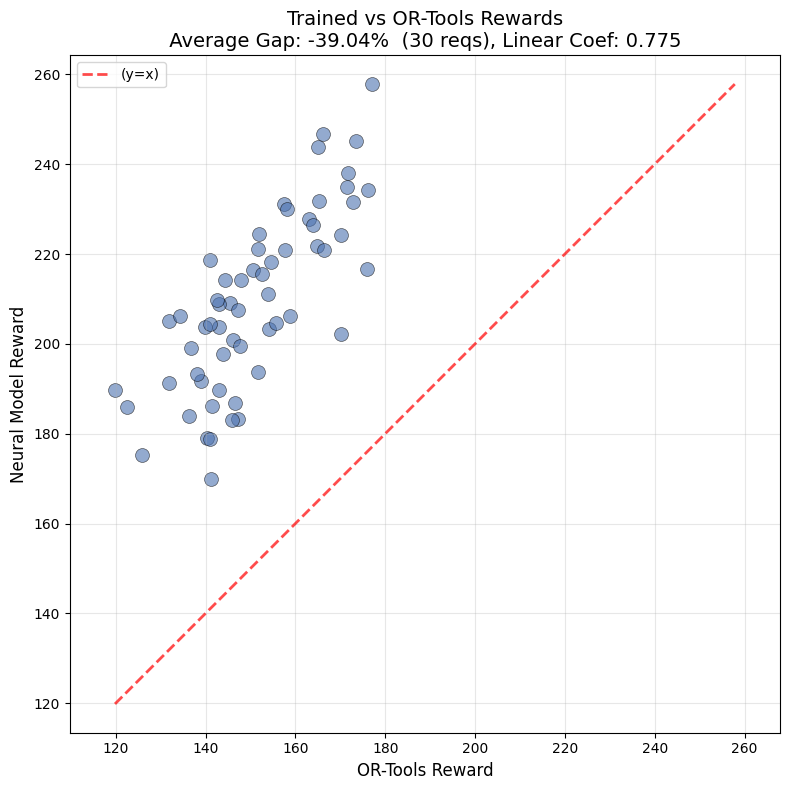

In [84]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Prepare data
trained_rewards = np.array(records["30 req"]["neural"])
or_rewards = np.array(records["30 req"]["or_tools"])

print(trained_rewards)
print(or_rewards)

# ---- Filter out -inf values ----
mask = (trained_rewards != -np.inf) & (or_rewards != -np.inf)
trained_rewards = trained_rewards[mask]
or_rewards = or_rewards[mask]
# --------------------------------

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(
    or_rewards,
    trained_rewards,
    alpha=0.6,
    s=100,
    color='#4c72b0',
    edgecolors='black',
    linewidth=0.5
)

# Add diagonal reference line
min_val = min(or_rewards.min(), trained_rewards.min())
max_val = max(or_rewards.max(), trained_rewards.max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    'r--',
    linewidth=2,
    label='(y=x)',
    alpha=0.7
)

# Labels and title
plt.xlabel("OR-Tools Reward", fontsize=12)
plt.ylabel("Neural Model Reward", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Mean optimality gap (only for valid points)
gap = np.mean((or_rewards - trained_rewards) / np.abs(or_rewards)) * 100
slope, intercept, r_value, p_value, std_err = stats.linregress(or_rewards, trained_rewards)
plt.title(f"Trained vs OR-Tools Rewards\n Average Gap: {gap:.2f}%  (30 reqs), Linear Coef: {r_value:.3f} ",fontsize=14)

plt.tight_layout()
plt.show()

In [226]:
def check_pairwise_validity(seq: torch.Tensor) -> bool:
    """
    Check if every subroute (separated by 0) contains only valid (2i-1, 2i) pairs.
    A pair is valid if for every request i, either both nodes (2i-1 and 2i)
    appear together in the same slice or neither appears at all.
    """
    # Convert tensor to list
    arr = seq.tolist()
    # Split by 0
    slices = []
    cur = []
    for x in arr:
        if x == 0:
            if cur:
                slices.append(cur)
                cur = []
        else:
            cur.append(x)
    if cur:
        slices.append(cur)

    # Check each slice
    for s in slices:
        s_set = set(s)
        for i in range(1, (max(s) // 2) + 2):
            a, b = 2 * i - 1, 2 * i
            in_a, in_b = a in s_set, b in s_set
            if in_a ^ in_b:  # only one of them is present
                return False
    return True

check_pairwise_validity(actions_trained[0])

False

/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:186: RuntimeWarning: vehicle cannot perform service and get back to depot in time.
  warnings.warn(
/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


FalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalse

/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrp/env.py:191: RuntimeWarning: Used more than capacity
  warnings.warn("Used more than capacity", RuntimeWarning)


FalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalse

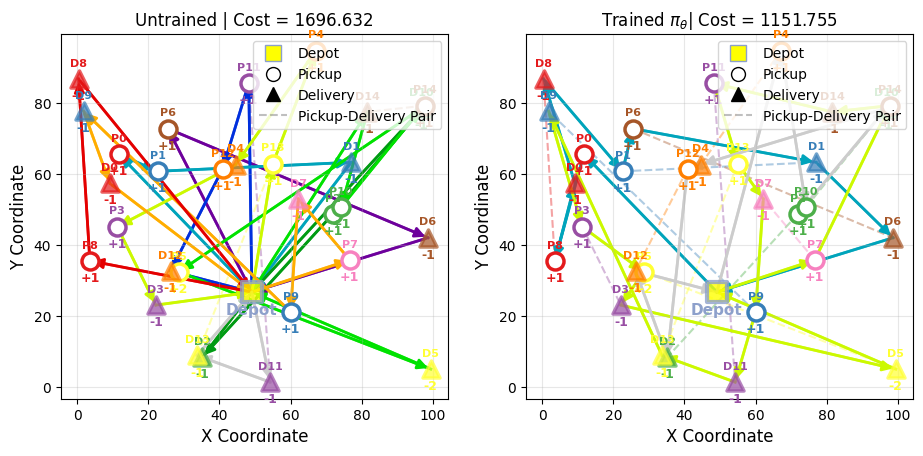

In [227]:
# Compare policy with untrained policy
check = False
while check == False: 
      
  # Testing: Greedy rollouts over trained model (same states as previous plot)
  env = PDPTWEnv(generator_params={"num_loc":30})
  td_init = env.reset(batch_size=[1]).to(device)

  out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
  actions_trained = out['actions'].cpu().detach()
  rewards_trained = out['reward']
  check = check_pairwise_validity(actions_trained[0])
  print(check, end='')
  

untrained_policy = AttentionModelPolicy(env_name=env.name, 
                              embed_dim=128,
                              num_encoder_layers=3,
                              num_heads=8
                            )

untrained_out = untrained_policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = untrained_out['actions'].cpu().detach()
rewards_untrained = untrained_out['reward']



# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

print(actions_trained)
